Value at Risk for Stock Market Trends

In [83]:
import numpy
import scipy.stats
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
yf.pdr_override()

In [84]:
start = '2009-01-11' 
end = '2018-01-01'
df = pdr.get_data_yahoo("AMD", start, end)

[*********************100%***********************]  1 of 1 downloaded


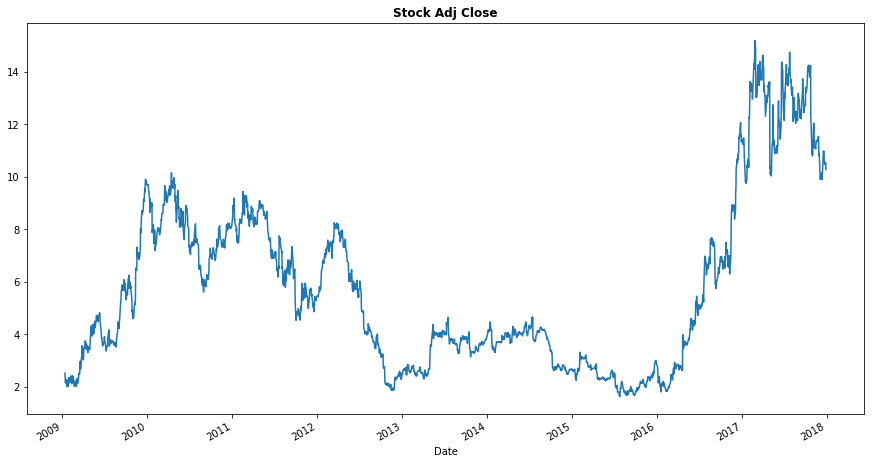

In [85]:
plt.figure(figsize=(15,8))
df["Adj Close"].plot()
plt.title("Stock Adj Close", weight='bold')
plt.show()

In [86]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-01-12,2.69,2.69,2.45,2.52,2.52,13085600
2009-01-13,2.42,2.47,2.30,2.38,2.38,21157100
2009-01-14,2.29,2.30,2.11,2.15,2.15,14821600
2009-01-15,2.15,2.30,2.05,2.26,2.26,16022500
2009-01-16,2.32,2.40,2.20,2.29,2.29,15182600


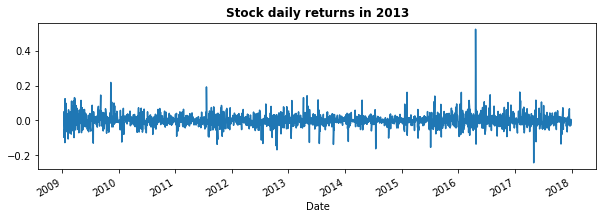

In [87]:
fig = plt.figure()
fig.set_size_inches(10,3)
df["Adj Close"].pct_change().plot()
plt.title(u"Stock daily returns in 2013", weight='bold');

0.03728859716060301

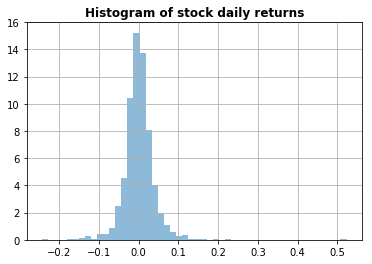

In [88]:
df["Adj Close"].pct_change().hist(bins=50, normed=True, histtype='stepfilled', alpha=0.5)
plt.title(u"Histogram of stock daily returns", weight='bold')
df["Adj Close"].pct_change().std()

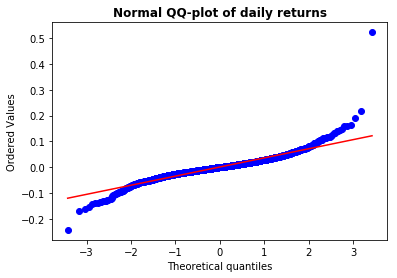

In [89]:
Q = df["Adj Close"].pct_change().dropna().as_matrix()
scipy.stats.probplot(Q, dist=scipy.stats.norm, plot=plt.figure().add_subplot(111))
plt.title("Normal QQ-plot of daily returns", weight="bold");

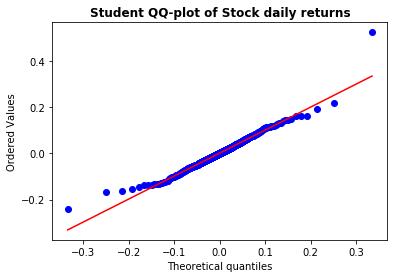

In [90]:
tdf, tmean, tsigma = scipy.stats.t.fit(Q)
scipy.stats.probplot(Q, dist=scipy.stats.t, sparams=(tdf, tmean, tsigma), plot=plt.figure().add_subplot(111))
plt.title("Student QQ-plot of Stock daily returns", weight="bold");

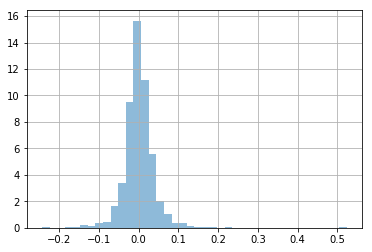

In [91]:
# VaR using the historical bootstrap method
returns = df["Adj Close"].pct_change().dropna()
mean = returns.mean()
sigma = returns.std()
tdf, tmean, tsigma = scipy.stats.t.fit(returns.as_matrix())
returns.hist(bins=40, normed=True, histtype='stepfilled', alpha=0.5);

In [92]:
returns.quantile(0.05)

-0.05263157894736839

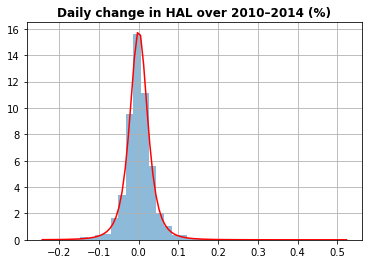

In [93]:
# VaR using the variance-covariance method
support = numpy.linspace(returns.min(), returns.max(), 100)
returns.hist(bins=40, normed=True, histtype='stepfilled', alpha=0.5);
plt.plot(support, scipy.stats.t.pdf(support, loc=tmean, scale=tsigma, df=tdf), "r-")
plt.title("Daily change in HAL over 2010–2014 (%)", weight='bold')
plt.show()

In [94]:
scipy.stats.norm.ppf(0.05, mean, sigma)

-0.06003052054204739

In [95]:
# VaR using Monte Carlo method
days = 300   # time horizon
dt = 1/float(days)
sigma = 0.04 # volatility
mu = 0.05  # drift (average growth rate)

In [96]:
def random_walk(startprice):
    price = numpy.zeros(days)
    shock = numpy.zeros(days)
    price[0] = startprice
    for i in range(1, days):
        shock[i] = numpy.random.normal(loc=mu * dt, scale=sigma * numpy.sqrt(dt))
        price[i] = max(0, price[i-1] + shock[i] * price[i-1])
    return price

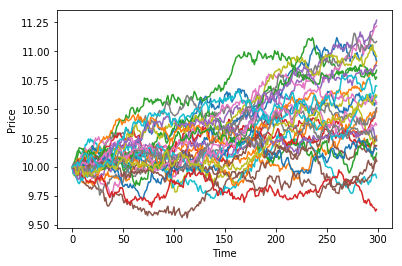

In [97]:
# Similuations
for run in range(30):
    plt.plot(random_walk(10.0))
plt.xlabel("Time")
plt.ylabel("Price");

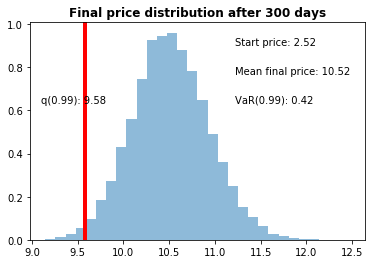

In [98]:
runs = 10000
simulations = numpy.zeros(runs)
for run in range(runs):
    simulations[run] = random_walk(10.0)[days-1]
q = numpy.percentile(simulations, 1)
plt.hist(simulations, normed=True, bins=30, histtype='stepfilled', alpha=0.5)
plt.figtext(0.6, 0.8, "Start price: %.2f" % df["Adj Close"][0])
plt.figtext(0.6, 0.7, "Mean final price: %.2f" % simulations.mean())
plt.figtext(0.6, 0.6, "VaR(0.99): %.2f" % (10 - q,))
plt.figtext(0.15, 0.6, "q(0.99): %.2f" % q)
plt.axvline(x=q, linewidth=4, color='r')
plt.title("Final price distribution after {} days".format(days), weight='bold');